"""
Skin cancer lesion classification using the HAM10000 dataset

Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description:
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

The 7 classes of skin cancer lesions included in this dataset are:

Melanocytic nevi (nv)

Melanoma (mel)

Benign keratosis-like lesions (bkl)

Basal cell carcinoma (bcc)

Actinic keratoses (akiec)

Vascular lesions (vasc)

Dermatofibroma (df)
"""

Now, Extracting the data from kaggle to Google Collab

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/skin_cancer.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Using GPU for running the project.

In [ ]:
import tensorflow as tf
device_list = tf.test.gpu_device_name()

In [ ]:
device_list

'/device:GPU:0'

Importing the necessary dependencies.
And reading the csv file.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

skin_df =  pd.read_csv('HAM10000_metadata.csv')



In [ ]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [ ]:
skin_df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000




Label Encoding after displaying the labels or target columns.

The use of LabelEncoder is to transform the target classes into the numeric forms.

In [ ]:
SIZE=64

le = LabelEncoder()

le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))



['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))



        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

In [ ]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
label            0
dtype: int64

In [ ]:
skin_df['age'].fillna(int(skin_df['age'].mean()),inplace=True)

In [ ]:
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
label           0
dtype: int64

In [ ]:
skin_df.describe() #Not needed.

,age,label
count,10015.000000,10015.000000
mean,51.858912,4.182327
std,16.920377,1.458742
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,5.000000
75%,65.000000,5.000000
max,85.000000,6.000000


Data distribution visualization

<ipython-input-19-d97bd7c382f9>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


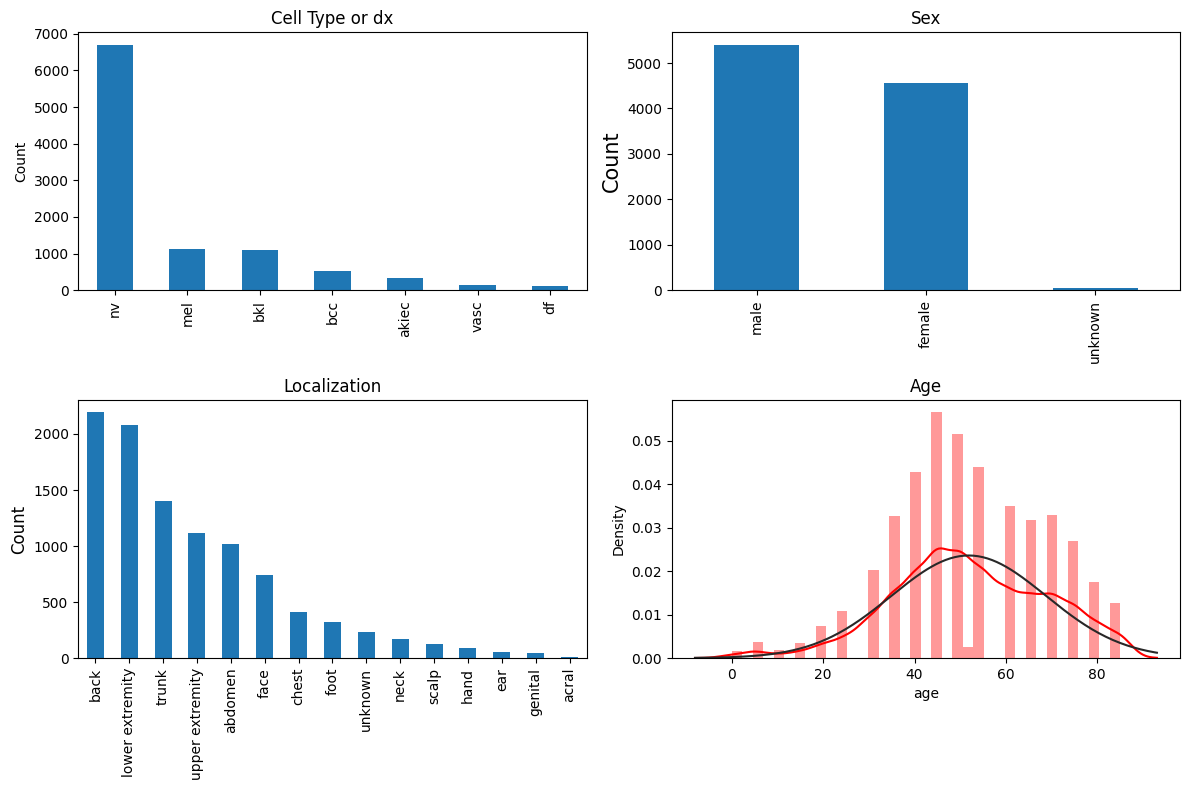

In [ ]:

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type or dx');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

Create the image_path dictionary

In [ ]:

base_skin_dir = '/content/All_images'
image_path =  {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}


Map the path with the image_id

In [ ]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,/content/All_images/HAM10000_images_part_1/ISI...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,/content/All_images/HAM10000_images_part_1/ISI...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,/content/All_images/HAM10000_images_part_1/ISI...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,/content/All_images/HAM10000_images_part_1/ISI...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,/content/All_images/HAM10000_images_part_2/ISI...


Now, create a new column image and store the pixel values of each image in particular column by mapping them to the path and resizing them.

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,/content/All_images/HAM10000_images_part_1/ISI...,"[[[191, 152, 194], [191, 153, 195], [192, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,/content/All_images/HAM10000_images_part_1/ISI...,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,/content/All_images/HAM10000_images_part_1/ISI...,"[[[186, 129, 140], [192, 136, 151], [198, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,/content/All_images/HAM10000_images_part_1/ISI...,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,/content/All_images/HAM10000_images_part_2/ISI...,"[[[139, 95, 118], [158, 114, 138], [178, 133, ..."


Plot the 5 samples of each classes related to that image.

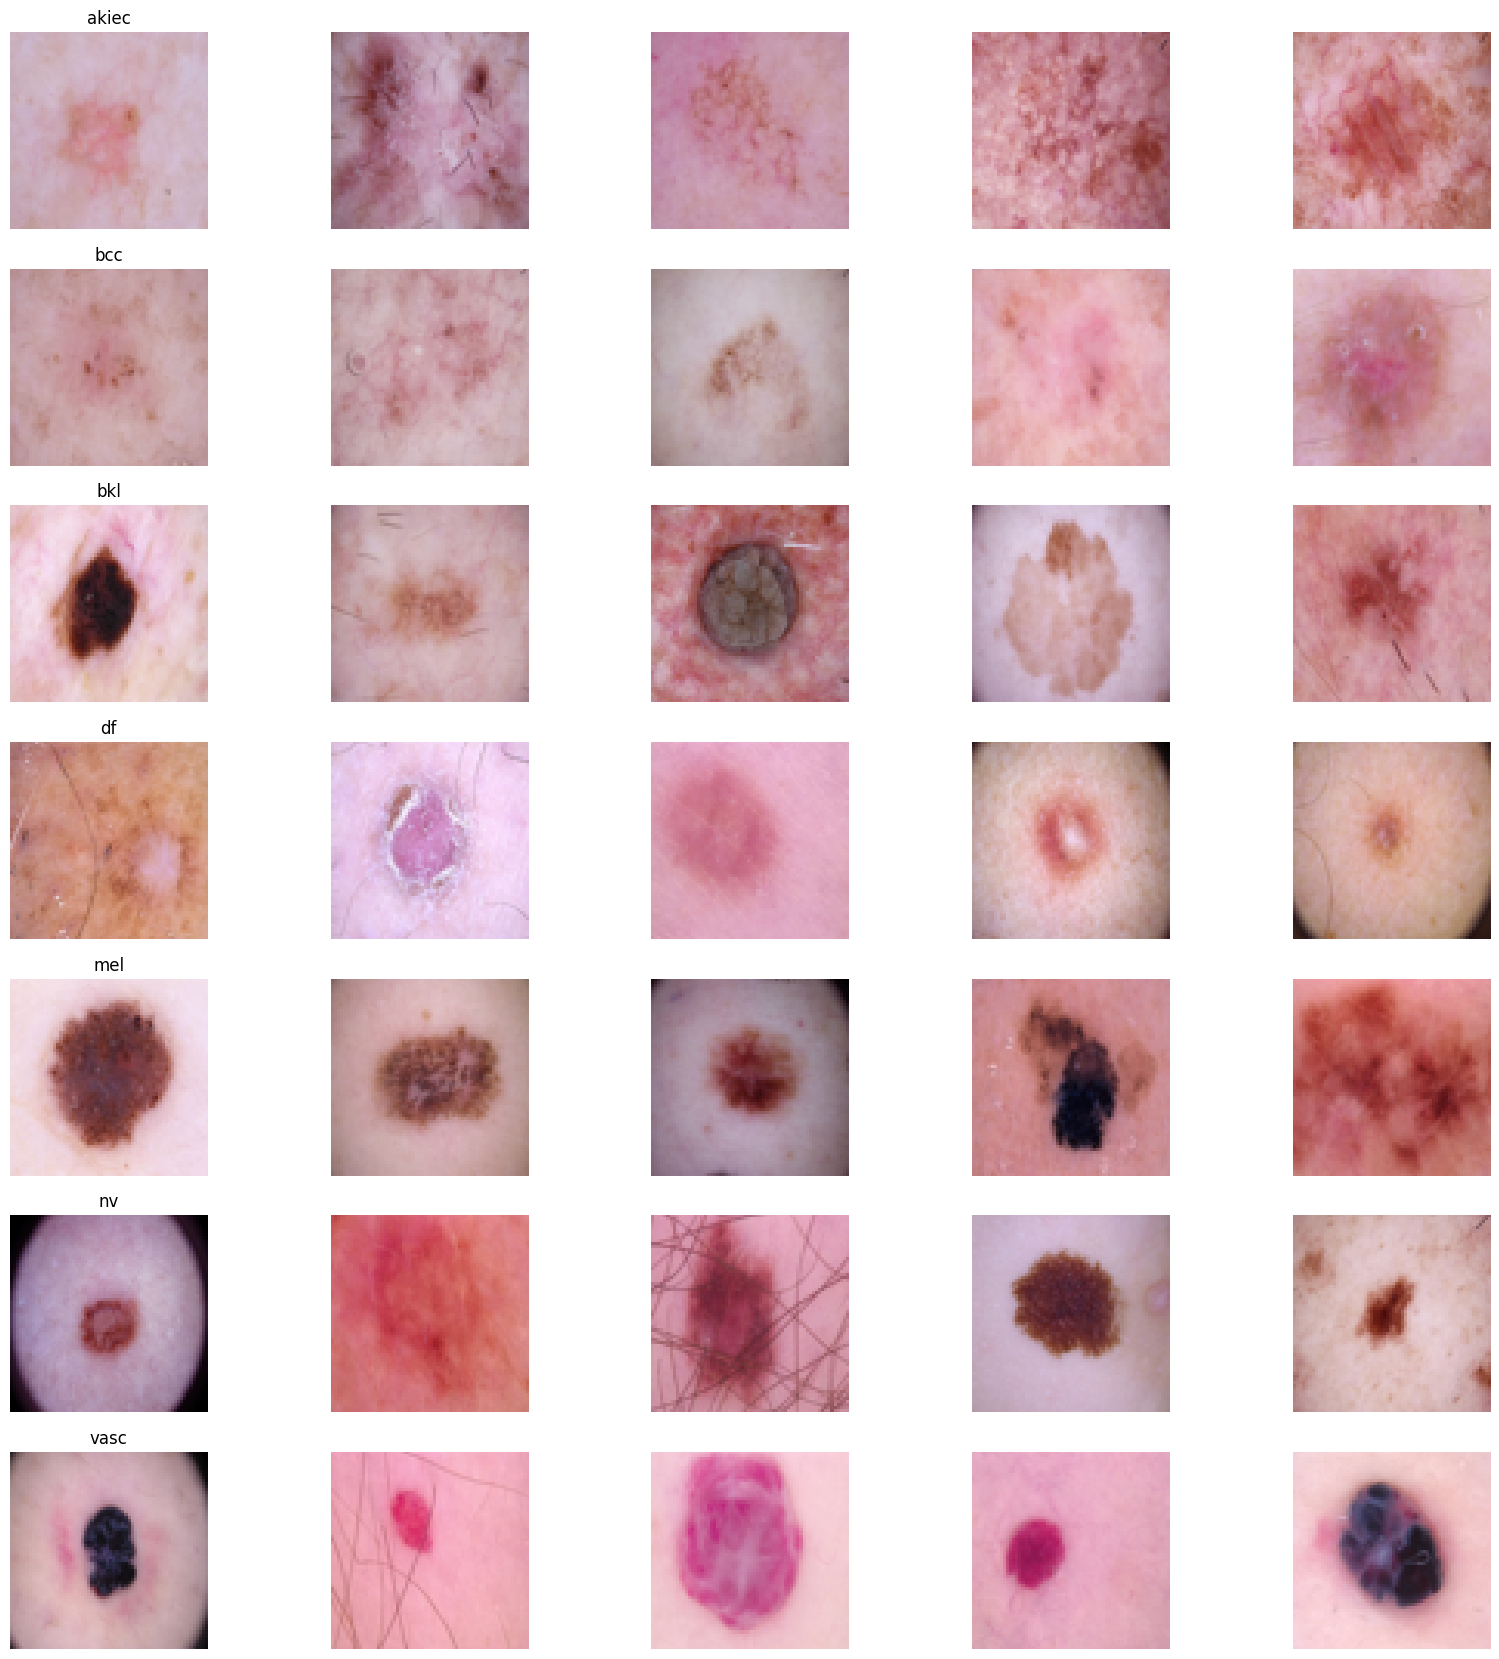

In [ ]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [ ]:
skin_df['label'].unique()

array([2, 5, 3, 4, 6, 1, 0])

In [ ]:
skin_df['label']

0        2
1        2
2        2
3        2
4        2
        ..
10010    0
10011    0
10012    0
10013    0
10014    4
Name: label, Length: 10015, dtype: int64

In [ ]:

#Convert dataframe column of images into numpy array
X = np.asarray(skin_df['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.3, random_state=42)


In [ ]:
print(len(x_train))

7010


In [ ]:
print(SIZE)

64


Creating the CNN model for training the data.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))

# Flatten the feature maps
model.add(Flatten())

# Dense (fully connected) layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Precision'])

# Summary of the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 32)         

Fit the data in that model and see the precision and loss.

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=25,
    batch_size = 100,
    validation_data=(x_test, y_test),
    verbose=2)




Epoch 1/25
71/71 - 6s - loss: 1.2226 - precision: 0.7523 - val_loss: 1.0103 - val_precision: 0.8257 - 6s/epoch - 82ms/step
Epoch 2/25
71/71 - 1s - loss: 1.0394 - precision: 0.8131 - val_loss: 0.9359 - val_precision: 0.8325 - 1s/epoch - 15ms/step
Epoch 3/25
71/71 - 1s - loss: 0.9974 - precision: 0.8209 - val_loss: 0.9107 - val_precision: 0.8021 - 1s/epoch - 16ms/step
Epoch 4/25
71/71 - 1s - loss: 0.9540 - precision: 0.8281 - val_loss: 0.8910 - val_precision: 0.8018 - 1s/epoch - 17ms/step
Epoch 5/25
71/71 - 1s - loss: 0.9254 - precision: 0.8276 - val_loss: 0.8864 - val_precision: 0.8587 - 1s/epoch - 18ms/step
Epoch 6/25
71/71 - 1s - loss: 0.9176 - precision: 0.8278 - val_loss: 0.8576 - val_precision: 0.8171 - 1s/epoch - 16ms/step
Epoch 7/25
71/71 - 1s - loss: 0.8882 - precision: 0.8279 - val_loss: 0.8582 - val_precision: 0.8165 - 1s/epoch - 15ms/step
Epoch 8/25
71/71 - 1s - loss: 0.8721 - precision: 0.8333 - val_loss: 0.8276 - val_precision: 0.8555 - 1s/epoch - 17ms/step
Epoch 9/25
71/71

Plotting the graph of both traininig loss and validation loss at each epoch.

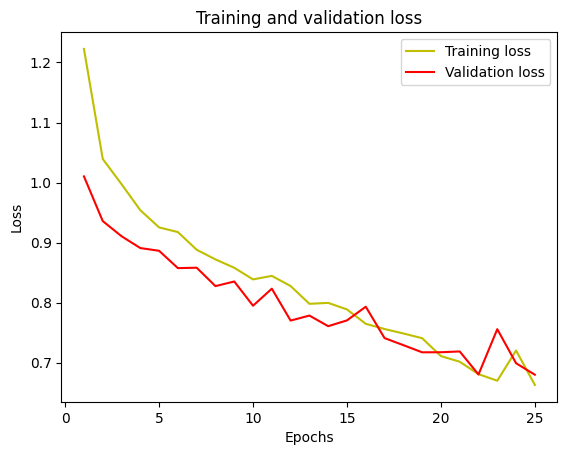

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction on testing data.


In [ ]:
y_test_pred = model.predict(x_test)

94/94 [==============================] - 1s 4ms/step


In [ ]:
y_train_pred = model.predict(x_train)

220/220 [==============================] - 1s 5ms/step


 Create scatter plots for training and testing data.


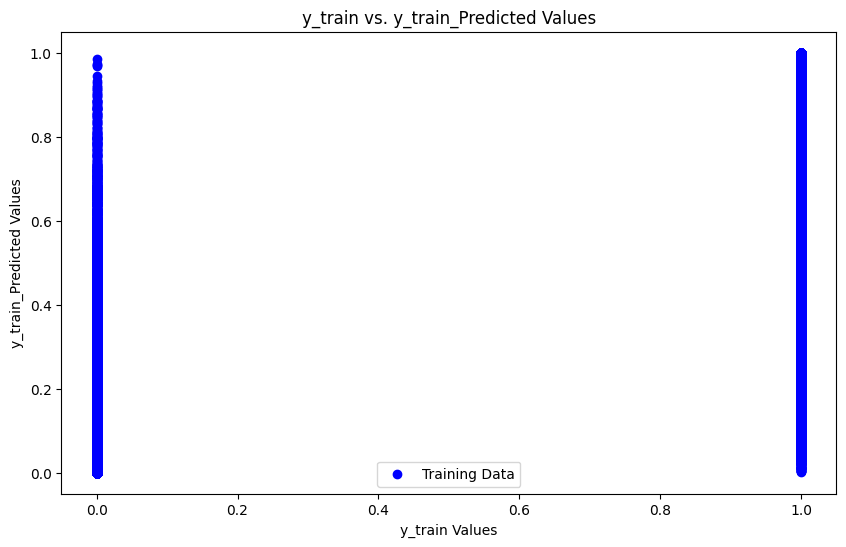

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Training Data')
# plt.scatter(y_test, y_test_pred, color='red', label='Testing Data')
plt.xlabel('y_train Values')
plt.ylabel('y_train_Predicted Values')
plt.title('y_train vs. y_train_Predicted Values')
plt.legend()
plt.show()

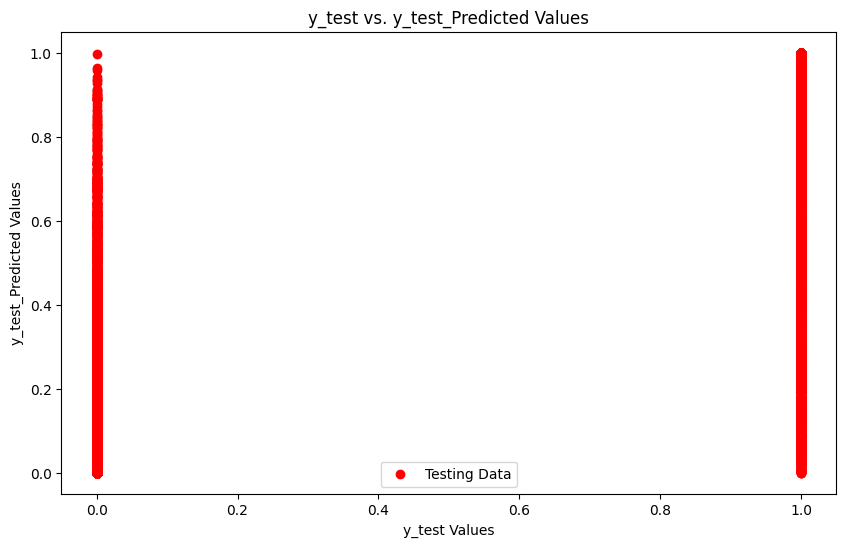

In [ ]:
plt.figure(figsize=(10, 6))
# plt.scatter(y_train, y_train_pred, color='blue', label='Training Data')
plt.scatter(y_test, y_test_pred, color='red', label='Testing Data')
plt.xlabel('y_test Values')
plt.ylabel('y_test_Predicted Values')
plt.title('y_test vs. y_test_Predicted Values')
plt.legend()
plt.show()

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
np.unique(y_train)

array([0., 1.], dtype=float32)

In [ ]:

score = model.evaluate(x_test, y_test)
print('Test precision:', score[1])

94/94 [==============================] - 1s 5ms/step - loss: 0.6801 - precision: 0.8393
Test precision: 0.8393387198448181


In [ ]:
y_train_pred

array([[6.5632783e-05, 6.5919617e-03, 7.4254116e-05, ..., 1.4042099e-04,
        2.1159626e-03, 9.9096608e-01],
       [2.2744566e-04, 2.9543153e-04, 4.1431051e-02, ..., 1.8934530e-01,
        7.6859069e-01, 4.5942154e-05],
       [5.0914328e-04, 1.4729219e-03, 5.6958329e-02, ..., 7.9169184e-02,
        8.6162955e-01, 7.1071387e-05],
       ...,
       [3.6559345e-07, 2.0753209e-06, 7.5199822e-04, ..., 6.3227559e-04,
        9.9860579e-01, 4.6951836e-06],
       [1.7759297e-03, 7.1426749e-04, 4.1284442e-01, ..., 4.0874195e-01,
        1.7580226e-01, 7.5763173e-06],
       [1.9129420e-02, 1.5806997e-02, 1.4062622e-01, ..., 2.5150254e-01,
        5.6486601e-01, 2.8803961e-03]], dtype=float32)

In [ ]:
y_test_pred

array([[3.2383554e-02, 1.0977514e-02, 5.5122644e-01, ..., 2.9016262e-01,
        1.1281933e-01, 1.2598350e-04],
       [1.0989779e-02, 1.6564725e-02, 1.3427372e-01, ..., 9.4071269e-02,
        7.3538268e-01, 2.7568170e-03],
       [2.2665887e-01, 1.2620424e-01, 2.2168386e-01, ..., 2.3600502e-01,
        1.2642154e-01, 1.8313624e-02],
       ...,
       [8.4233911e-08, 1.1414343e-06, 2.5159155e-04, ..., 4.3953671e-05,
        9.9969757e-01, 2.4617013e-06],
       [1.4396971e-03, 1.9218904e-04, 8.0608800e-02, ..., 6.5515810e-01,
        2.6256108e-01, 1.1867877e-05],
       [1.6302473e-04, 3.7384249e-05, 3.3335630e-02, ..., 5.2636153e-01,
        4.4009191e-01, 5.1426709e-06]], dtype=float32)

In [ ]:

y_test_pred[0]

array([3.2383554e-02, 1.0977514e-02, 5.5122644e-01, 2.3045447e-03,
       2.9016262e-01, 1.1281933e-01, 1.2598350e-04], dtype=float32)

In [ ]:
y_test[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

Now, using the model to predict in completely new data.

In [ ]:
new_testing_data = '/content/test_new_image.jpg'
new_testing_data=Image.open(new_testing_data)
new_testing_data = np.array(new_testing_data)

In [ ]:
new_testing_data

array([[[27, 19, 17],
        [29, 21, 19],
        [30, 22, 20],
        ...,
        [ 9,  4, 10],
        [ 9,  4, 10],
        [ 9,  4, 10]],

       [[27, 19, 17],
        [28, 20, 18],
        [30, 22, 20],
        ...,
        [ 9,  4, 10],
        [ 9,  4, 10],
        [ 9,  4, 10]],

       [[27, 19, 17],
        [28, 20, 18],
        [30, 22, 20],
        ...,
        [ 9,  4, 10],
        [ 9,  4, 10],
        [ 9,  4, 10]],

       ...,

       [[34, 24, 22],
        [35, 25, 23],
        [35, 25, 23],
        ...,
        [ 9,  4, 10],
        [ 9,  4, 10],
        [ 9,  4, 10]],

       [[34, 24, 22],
        [35, 25, 23],
        [35, 25, 23],
        ...,
        [ 9,  4, 10],
        [ 9,  4, 10],
        [ 9,  4, 10]],

       [[34, 24, 22],
        [35, 25, 23],
        [35, 25, 23],
        ...,
        [ 9,  4, 10],
        [ 9,  4, 10],
        [ 9,  4, 10]]], dtype=uint8)

In [ ]:
new_testing_data = np.resize(new_testing_data, (1, 64, 64, 3))

 In this context:

 1: This typically represents the batch size.
    It means that there is one image in the batch.
    In machine learning and deep learning, it's common to process images
    in batches to make computations more efficient.

 64: This represents the height of the image, indicating that the image has a height of 64 pixels.

 64: This represents the width of the image, indicating that the image has a width of 64 pixels.

 3: This represents the number of channels in the image.
 For a color image in RGB format, there are typically 3 channels:
  one for red, one for green, and one for blue. Each channel stores pixel values for a specific color component.

In [ ]:
new_testing_data.shape

(1, 64, 64, 3)

In [ ]:
x_train.shape

(7010, 64, 64, 3)

In [ ]:
model.predict(new_testing_data)

1/1 [==============================] - 0s 34ms/step


array([[2.2451177e-08, 4.3377733e-09, 1.9403019e-03, 1.6311412e-10,
        3.0361491e-01, 6.9444478e-01, 1.7628669e-10]], dtype=float32)

 Here, the highest probability is 6.9444478e-01 which is 0.694. Hence the model detects the image with the disease of
'nv' or 'Melanocytic nevi'.